## Import necessary libraries

In [2]:

import os
import shutil
import random
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from skimage.io import imread
from tqdm import tqdm
import pandas as pd
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier, plot_importance
from skimage.io import imread
from skimage.measure import shannon_entropy


2025-05-10 22:09:46.380824: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-10 22:09:46.390490: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-10 22:09:46.459956: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-10 22:09:46.519745: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746911386.571388  772176 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746911386.58

The original dataset can be found at: https://www.kaggle.com/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy/data

The dataset is a collection of MRI images of patients with Alzheimer's disease and healthy individuals. It's already preprocessed and split into training and testing sets.

In the following code, we split 15% of the training set into a validation set.

In [3]:
source_train_dir = './original_data/train'
source_test_dir = './original_data/test'
target_base = 'data'

split_ratios = [0.85, 0.15]

#Limpeza caso já tenha sido executado este bloco antes
for subset in ['train', 'val', 'test']:
    subset_path = os.path.join(target_base, subset)
    if os.path.exists(subset_path):
        print(f"Removing old {subset} directory...")
        shutil.rmtree(subset_path)

for class_name in os.listdir(source_train_dir):
    class_path = os.path.join(source_train_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    files = [f for f in os.listdir(class_path) if not f.startswith('.')] 
    random.shuffle(files)

    total = len(files)
    train_end = int(split_ratios[0] * total)

    train_files = files[:train_end]
    val_files = files[train_end:]

    print(f"{class_name}: Total={total}, Train={len(train_files)}, Val={len(val_files)}")

    for split, split_files in zip(['train', 'val'], [train_files, val_files]):
        split_dir = os.path.join(target_base, split, class_name)
        os.makedirs(split_dir, exist_ok=True)
        for file in split_files:
            src = os.path.join(class_path, file)
            dst = os.path.join(split_dir, file)
            shutil.copy2(src, dst)

for class_name in os.listdir(source_test_dir):
    class_path = os.path.join(source_test_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    target_class_dir = os.path.join(target_base, 'test', class_name)
    os.makedirs(target_class_dir, exist_ok=True)

    test_files = [f for f in os.listdir(class_path) if not f.startswith('.')]
    print(f"{class_name} Test: {len(test_files)} images")

    for file in test_files:
        src = os.path.join(class_path, file)
        dst = os.path.join(target_class_dir, file)
        shutil.copy2(src, dst)


Removing old train directory...
Removing old val directory...
Removing old test directory...
Moderate Impairment: Total=2560, Train=2176, Val=384
Mild Impairment: Total=2560, Train=2176, Val=384
No Impairment: Total=2560, Train=2176, Val=384
Very Mild Impairment: Total=2560, Train=2176, Val=384
Moderate Impairment Test: 12 images
Mild Impairment Test: 179 images
No Impairment Test: 640 images
Very Mild Impairment Test: 448 images


In the next code block, we print and plot important information about the dataset, including the number of images in each class and subset and also the distribution of images in each class.

Distribution of Images in Each Subset:
Mild Impairment: Train: 2176, Val: 384, Test: 179
Moderate Impairment: Train: 2176, Val: 384, Test: 12
No Impairment: Train: 2176, Val: 384, Test: 640
Very Mild Impairment: Train: 2176, Val: 384, Test: 448


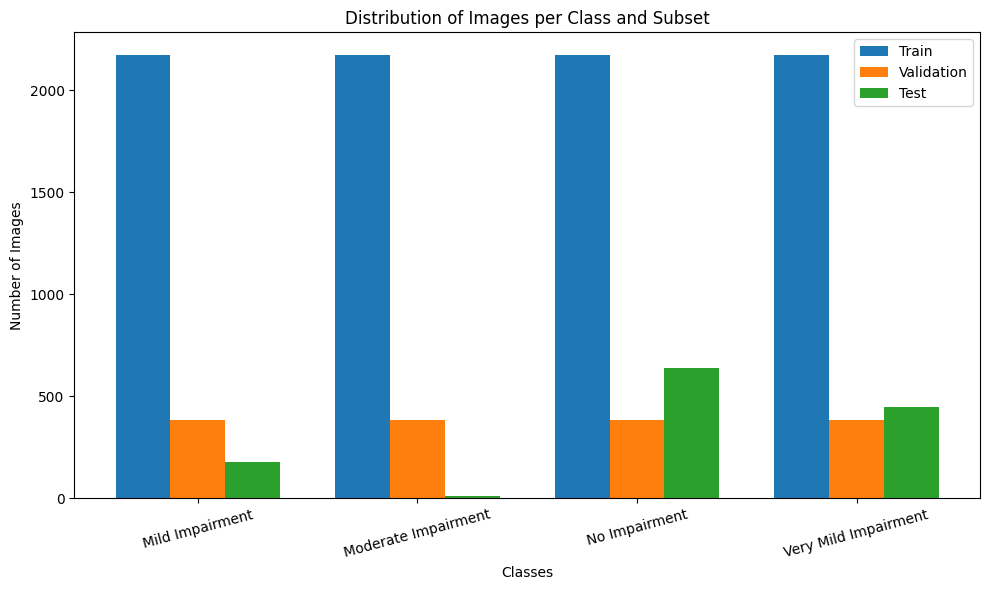

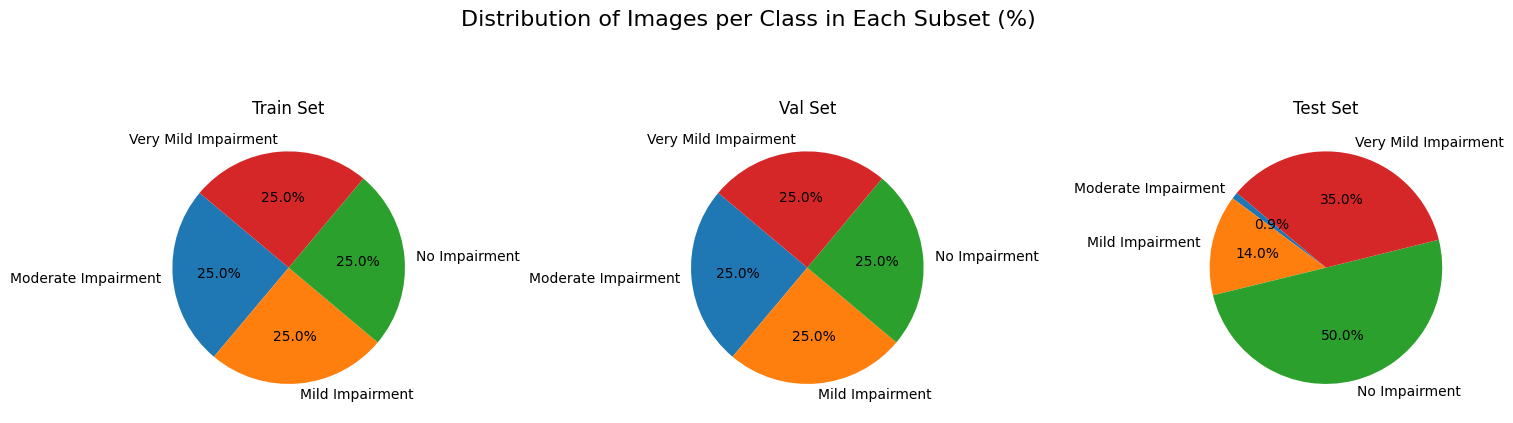

In [5]:
base_path = "./data" 

data_counts = {
    "train": defaultdict(int),
    "val": defaultdict(int),
    "test": defaultdict(int)
}

for subset in data_counts.keys():
    subset_path = os.path.join(base_path, subset)
    for label in os.listdir(subset_path):
        label_path = os.path.join(subset_path, label)
        count = len(os.listdir(label_path))
        data_counts[subset][label] = count

labels = sorted(list(data_counts["train"].keys()))
x = range(len(labels))
bar_width = 0.25

train_counts = [data_counts["train"][label] for label in labels]
val_counts = [data_counts["val"][label] for label in labels]
test_counts = [data_counts["test"][label] for label in labels]

print("Distribution of Images in Each Subset:")
for label in labels:
    print(f"{label}: Train: {data_counts['train'][label]}, Val: {data_counts['val'][label]}, Test: {data_counts['test'][label]}")

plt.figure(figsize=(10, 6))
plt.bar([i - bar_width for i in x], train_counts, width=bar_width, label='Train')
plt.bar(x, val_counts, width=bar_width, label='Validation')
plt.bar([i + bar_width for i in x], test_counts, width=bar_width, label='Test')

plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.title("Distribution of Images per Class and Subset")
plt.xticks(ticks=x, labels=labels, rotation=15)
plt.legend()
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, subset in enumerate(["train", "val", "test"]):
    counts = data_counts[subset]
    axes[i].pie(
        counts.values(),
        labels=counts.keys(),
        autopct='%1.1f%%',
        startangle=140
    )
    axes[i].set_title(f"{subset.capitalize()} Set")

plt.suptitle("Distribution of Images per Class in Each Subset (%)", fontsize=16)
plt.tight_layout()
plt.show()


rogosidade, luminosidade, contornos, areas
ferrramentas de processamento de imagem médica ( python, kaggle, ...)
para nos dar as features

CNN ESTUDAR AS CAMADAS E VER OQ ELAS ESTAO A FAZER
neurokit
machine learning com estas features vs deep learning


Here we plot a few sample images from the dataset to visualize the data.

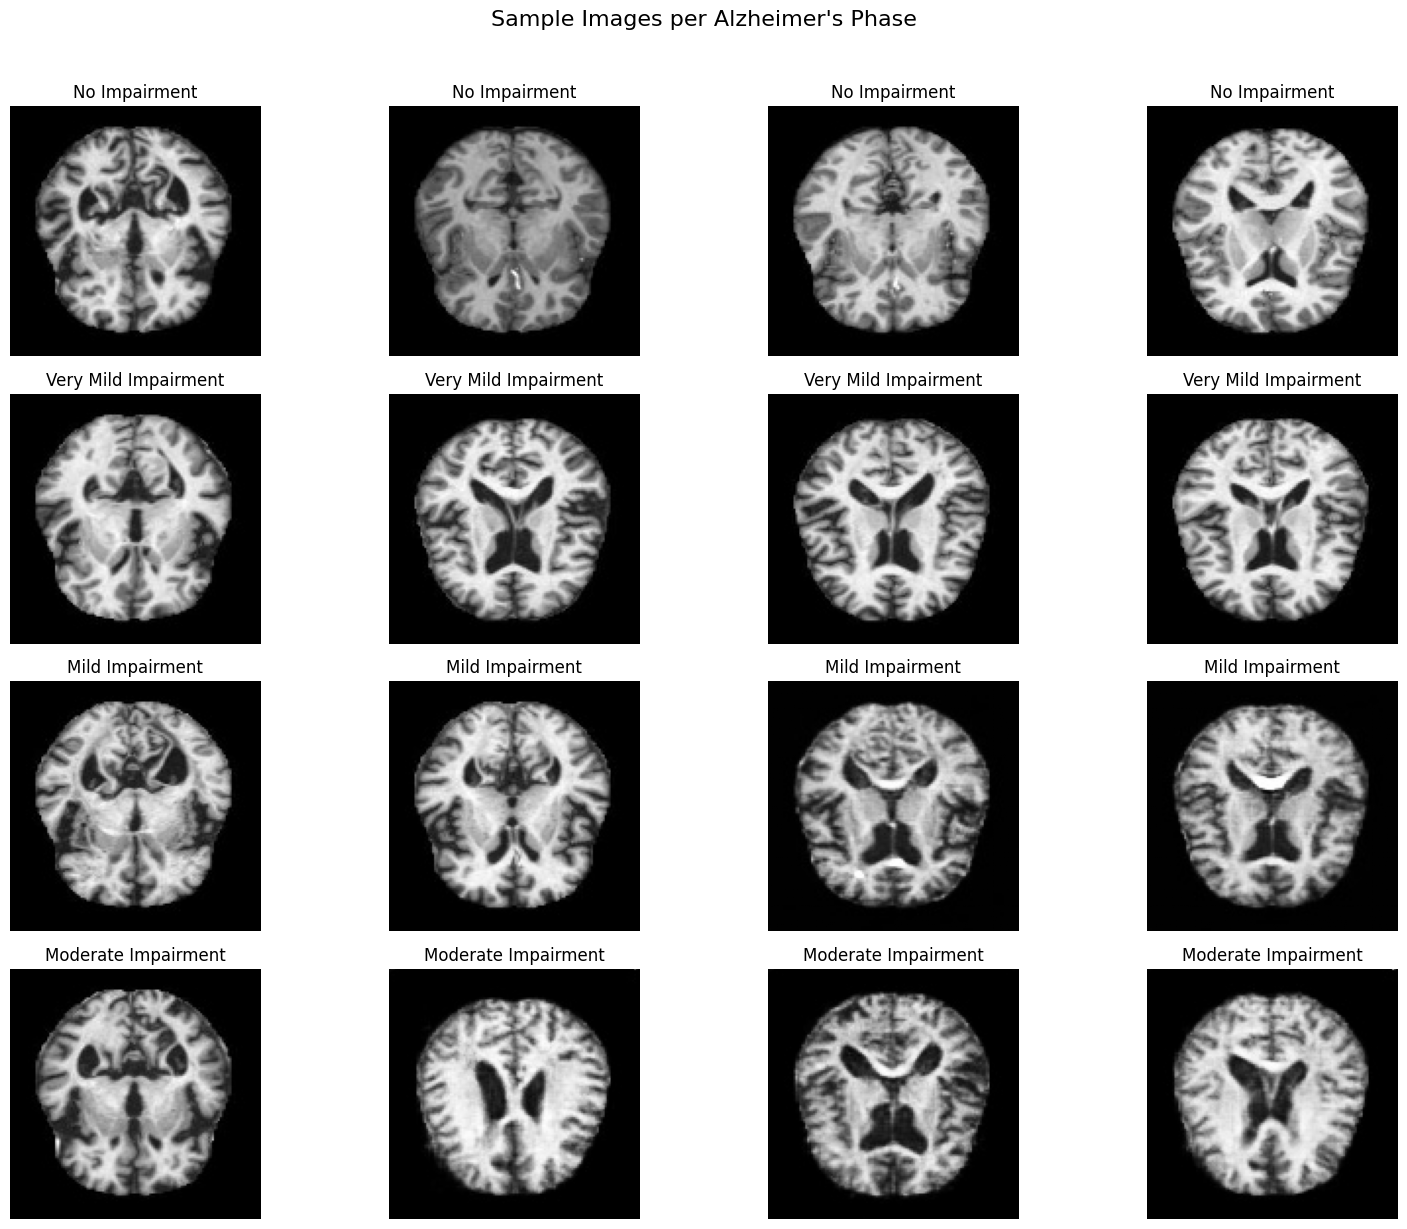

In [6]:

dataset_path = "./data/train" 

ordered_classes = [
    "No Impairment",          
    "Very Mild Impairment",   
    "Mild Impairment",        
    "Moderate Impairment"     
]

available_classes = os.listdir(dataset_path)
classes = [cls for cls in ordered_classes if cls in available_classes]

n_images = 4

plt.figure(figsize=(n_images * 4, len(classes) * 3))
img_index = 1

for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    images = sorted([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

    for i in range(min(n_images, len(images))):
        img_path = os.path.join(class_path, images[i])
        try:
            img = Image.open(img_path)
            plt.subplot(len(classes), n_images, img_index)
            plt.imshow(img, cmap='gray')
            plt.title(cls)
            plt.axis('off')
            img_index += 1
        except Exception as e:
            print(f"Erro ao abrir imagem {img_path}: {e}")

plt.suptitle("Sample Images per Alzheimer's Phase", fontsize=16, y=1.02) 
plt.tight_layout()
plt.show()


Here we go into more detail about the dataset, including the size of the images, the mode of the images (grayscale or RGB).


Tamanhos de imagem (largura x altura):
(128, 128): 8704 imagens

Modos de cor encontrados:
L: 8704 imagens

Número de imagens por classe:
Mild Impairment: 2176
Moderate Impairment: 2176
No Impairment: 2176
Very Mild Impairment: 2176


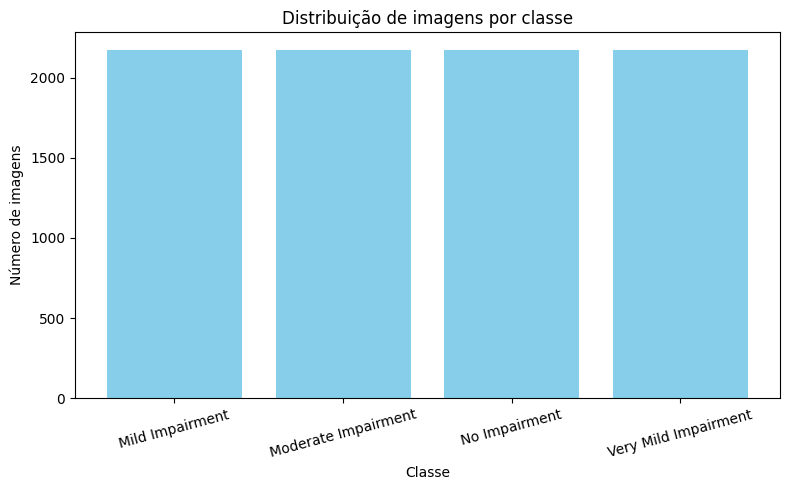

In [7]:
image_shapes = defaultdict(int)
color_modes = defaultdict(int)
class_counts = {}

for cls in sorted(os.listdir(dataset_path)):
    class_path = os.path.join(dataset_path, cls)
    if not os.path.isdir(class_path):
        continue

    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    class_counts[cls] = len(images)

    for img_file in images:
        img_path = os.path.join(class_path, img_file)
        try:
            with Image.open(img_path) as img:
                image_shapes[img.size] += 1
                color_modes[img.mode] += 1
        except Exception as e:
            print(f"Erro ao abrir imagem: {img_path}\n{e}")

print("\nTamanhos de imagem (largura x altura):")
for shape, count in image_shapes.items():
    print(f"{shape}: {count} imagens")

print("\nModos de cor encontrados:")
for mode, count in color_modes.items():
    print(f"{mode}: {count} imagens")

print("\nNúmero de imagens por classe:")
for cls, count in class_counts.items():
    print(f"{cls}: {count}")

plt.figure(figsize=(8, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel("Classe")
plt.ylabel("Número de imagens")
plt.title("Distribuição de imagens por classe")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()



## 🧠 Feature Extraction to Create a dataset to be used in a Machine Learning Modal
First we define labels for the classes in the dataset. The labels are as follows:
- No Impairment': 0,
- Very Mild Impairment': 1,
- Mild Impairment': 2,
- Moderate Impairment': 3


### 🔹 `extract_features(image)`

This function takes a single grayscale image as input and extracts a set of quantitative features:

- **Intensity-based features**:
  - `mean_intensity`: Average pixel value
  - `std_intensity`: Standard deviation of pixel values
  - `min_intensity`: Minimum pixel intensity
  - `max_intensity`: Maximum pixel intensity

- **GLCM (Gray-Level Co-occurrence Matrix) texture features**:
  These capture spatial relationships between pixel intensities:
  - `glcm_contrast`
  - `glcm_dissimilarity`
  - `glcm_homogeneity`
  - `glcm_energy`
  - `glcm_correlation`
  - `glcm_ASM`

- **LBP (Local Binary Pattern) histogram features**:
  Describes local texture patterns around each pixel. The result is a normalized histogram:
  - `lbp_bin_0` to `lbp_bin_10`: 11 bins representing frequency of texture patterns.

The function returns a dictionary where keys are feature names and values are the computed measurements.

Then with the function 'build_dataset' we create a dataset with the features extracted from the images.

This function loops through each class folder in the dataset directory and builds a DataFrame of extracted features:

1. Iterates through class-named subdirectories in `image_dir`.
2. Loads each image in grayscale.
3. Applies `extract_features()` to extract feature values.
4. Appends the class label (both string and numeric) to the result.

Returns a `pandas.DataFrame` with:
- One row per image
- Columns for each extracted feature
- `label_name`: The string label (e.g., `'Mild Impairment'`)
- `label`: The corresponding numeric label (e.g., `2`)

This structured dataset is ready for input into classifiers such as Random Forest, SVM, or Logistic Regression.


In [8]:
label_encoding = {
    'No Impairment': 0,
    'Very Mild Impairment': 1,
    'Mild Impairment': 2,
    'Moderate Impairment': 3
}

# --- Fractal dimension (simple box-counting) ---
def fractal_dimension(Z):
    def boxcount(Z, k):
        S = Z[:Z.shape[0] - Z.shape[0] % k, :Z.shape[1] - Z.shape[1] % k]
        blocks = S.reshape(S.shape[0] // k, k, S.shape[1] // k, k)
        return np.sum(np.any(np.any(blocks, axis=3), axis=1))
    
    Z = Z > 0  # binarize
    sizes = [2, 4, 8, 16]
    counts = [boxcount(Z, size) for size in sizes]
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -coeffs[0]

# --- Feature Extraction ---
def extract_features(image):
    features = {}
    image = image.astype(np.uint8)

    # --- Intensity Stats ---
    features['mean_intensity'] = np.mean(image)
    features['std_intensity'] = np.std(image)
    features['max_intensity'] = np.max(image)
    features['p25_intensity'] = np.percentile(image, 25)
    features['p75_intensity'] = np.percentile(image, 75)

    # --- Entropy ---
    features['entropy'] = shannon_entropy(image)

    # --- Fractal Dimension ---
    features['fractal_dim'] = fractal_dimension(image)

    # --- Hemispheric Asymmetry ---
    h, w = image.shape
    left, right = image[:, :w//2], image[:, w//2:]
    features['asymmetry_mean'] = abs(np.mean(left) - np.mean(right))

    # --- GLCM Texture (angle 0°, distance 1) ---
    glcm = graycomatrix(image, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']:
        features[f'glcm_{prop}'] = graycoprops(glcm, prop)[0, 0]

    # --- LBP Histogram (radius 1, 8 points) ---
    lbp = local_binary_pattern(image, P=8, R=1, method='uniform')
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
    hist = hist.astype("float") / (hist.sum() + 1e-6)
    for i, h_val in enumerate(hist):
        features[f'lbp_bin_{i}'] = h_val

    return features

# --- Dataset Construction ---
def build_dataset(image_dir):
    feature_list = []

    for label_name in sorted(os.listdir(image_dir)):
        if label_name not in label_encoding:
            continue
        class_path = os.path.join(image_dir, label_name)
        for img_name in tqdm(os.listdir(class_path), desc=f"Processing '{label_name}'"):
            img_path = os.path.join(class_path, img_name)
            image = imread(img_path, as_gray=True)
            features = extract_features(image)
            features['label_name'] = label_name
            features['label'] = label_encoding[label_name]
            feature_list.append(features)

    df = pd.DataFrame(feature_list)
    return df



Here we use the functions defined above to create a .csv file with the features extracted from the images in the dataset. 

In [9]:
dataset_path = 'data/train'
df = build_dataset(dataset_path)
df.to_csv('train_features.csv', index=False)

dataset_path = 'data/val'
df_val = build_dataset(dataset_path)
df_val.to_csv('val_features.csv', index=False)

dataset_path = 'data/test'
df_test = build_dataset(dataset_path)
df_test.to_csv('test_features.csv', index=False)

print("Feature extraction complete. Saved to 'train_features_detailed.csv'.")


Processing 'Very Mild Impairment': 100%|██████████| 448/448 [00:02<00:00, 177.01it/s]

Feature extraction complete. Saved to 'train_features_detailed.csv'.


# Visualization of the new dataset generated from the original dataset (images)

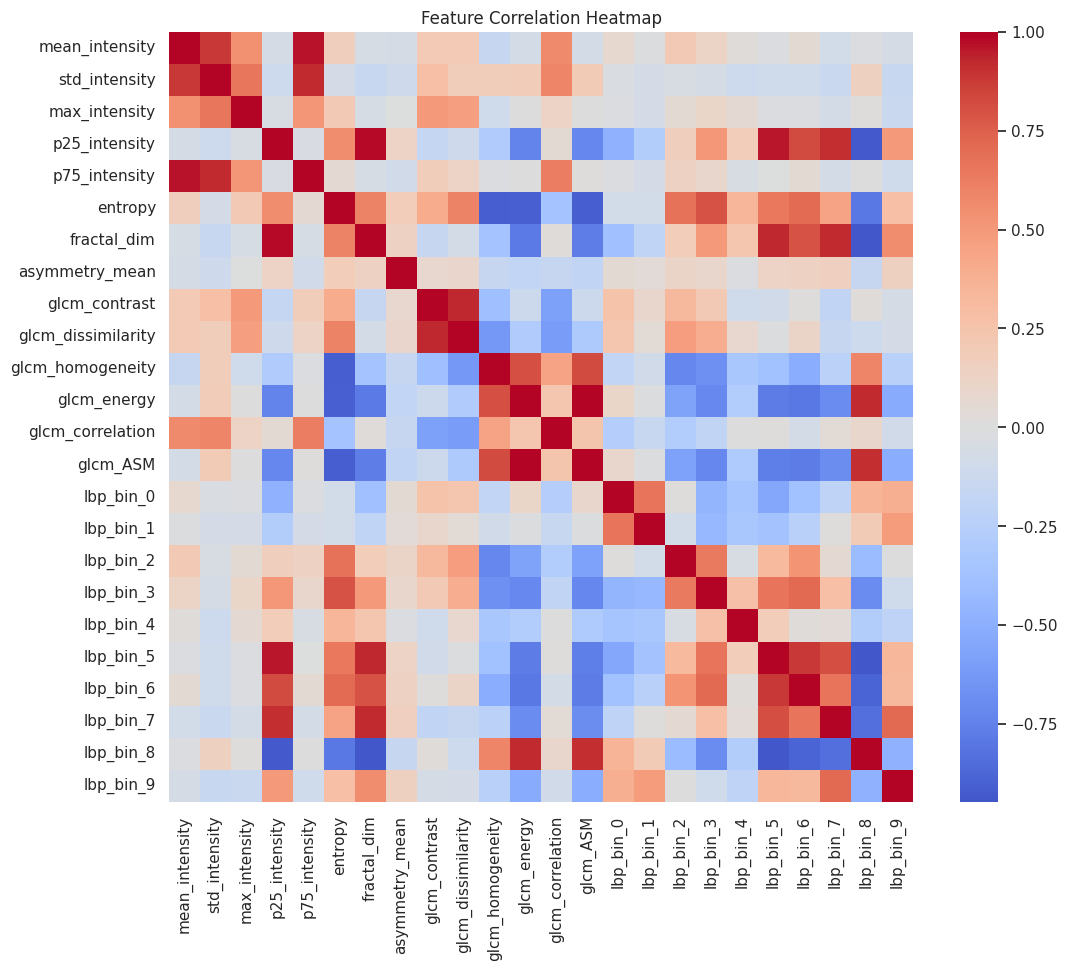

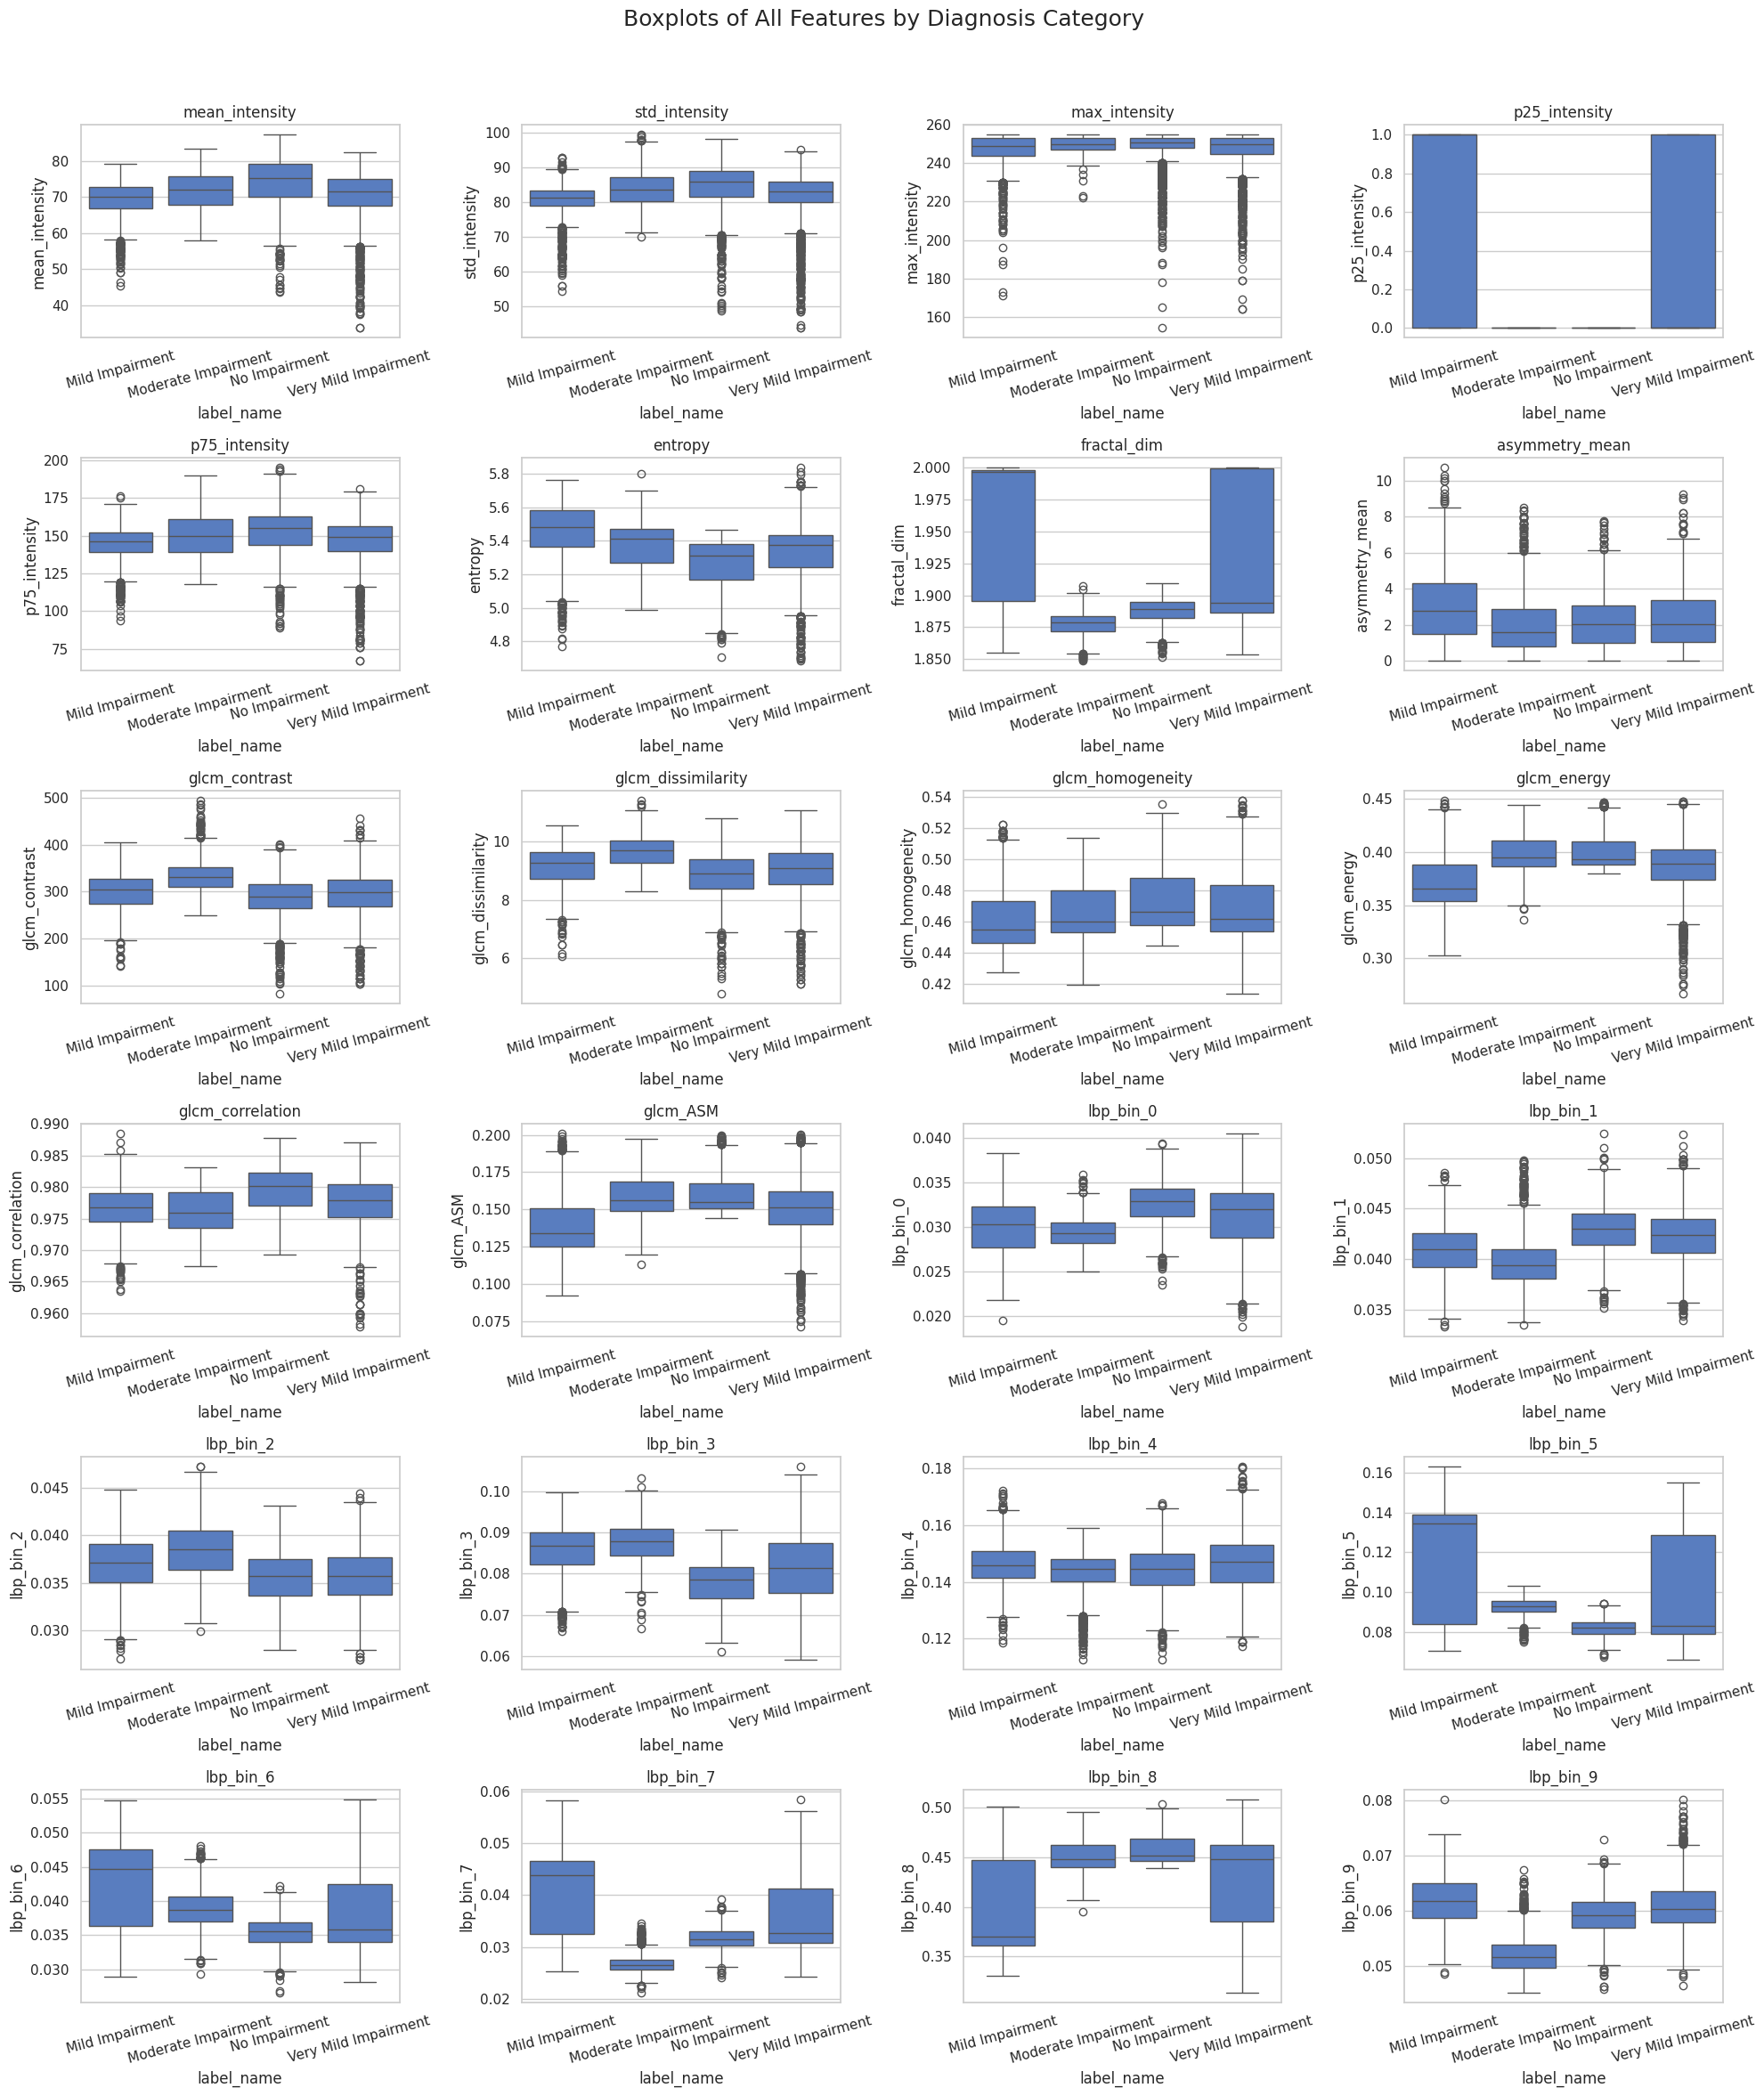

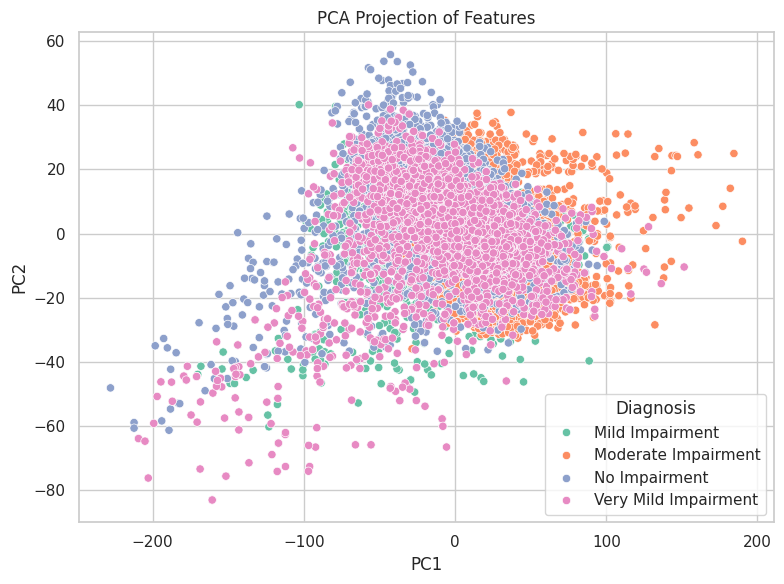

In [10]:
df = pd.read_csv("train_features.csv")
sns.set_theme(style="whitegrid", palette="muted")

label_map = {
    0: 'No Impairment',
    1: 'Very Mild Impairment',
    2: 'Mild Impairment',
    3: 'Moderate Impairment'
}
df['label_name'] = df['label'].map(label_map)

numeric_features = df.drop(columns=["label", "label_name"])

# --- Correlation Heatmap ---
plt.figure(figsize=(12, 10))
sns.heatmap(numeric_features.corr(), cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

# --- Boxplots for All Features ---
n_features = len(numeric_features.columns)
cols = 4  
rows = (n_features + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()

for i, feature in enumerate(numeric_features.columns):
    sns.boxplot(x='label_name', y=feature, data=df, ax=axes[i])
    axes[i].set_title(feature)
    axes[i].tick_params(axis='x', rotation=15)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Boxplots of All Features by Diagnosis Category", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()


# --- PCA Plot ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(numeric_features)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['label_name'], palette="Set2")
plt.title("PCA Projection of Features")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Diagnosis")
plt.tight_layout()
plt.show()

Top features by ANOVA F-score:
          Feature      F-score  p-value
21      lbp_bin_7  3207.634579      0.0
23      lbp_bin_9  2911.545618      0.0
6     fractal_dim  2272.817093      0.0
3   p25_intensity  2082.396528      0.0
19      lbp_bin_5  1597.921413      0.0
22      lbp_bin_8  1488.686780      0.0
17      lbp_bin_3  1102.251172      0.0
20      lbp_bin_6  1005.168154      0.0
11    glcm_energy   738.782027      0.0
15      lbp_bin_1   735.693453      0.0

Top features by Mutual Information:
          Feature  MI Score
19      lbp_bin_5  0.626799
21      lbp_bin_7  0.574245
6     fractal_dim  0.476898
23      lbp_bin_9  0.371769
22      lbp_bin_8  0.339618
20      lbp_bin_6  0.309591
3   p25_intensity  0.245541
17      lbp_bin_3  0.229602
14      lbp_bin_0  0.223253
11    glcm_energy  0.223085


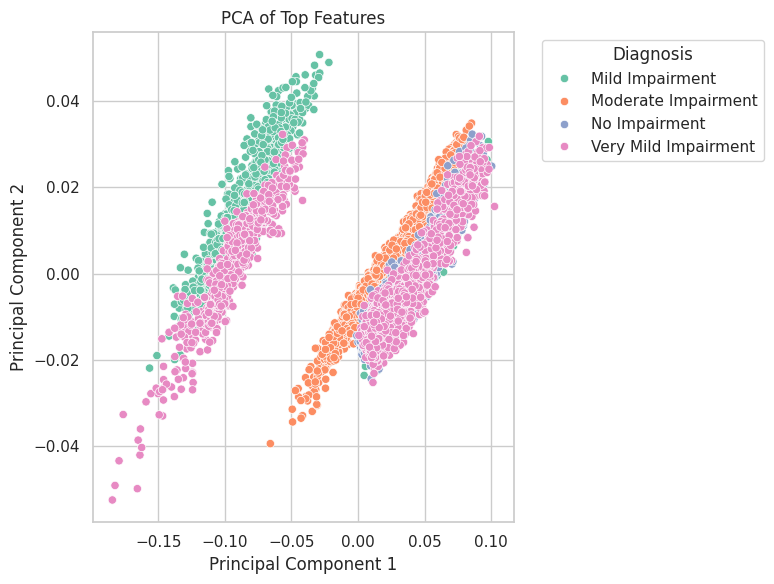

In [11]:
# Load your dataset
df = pd.read_csv("train_features.csv")

# Separate features and label
X = df.drop(columns=["label", "label_name"], errors="ignore")
y = df["label"]

# --- ANOVA F-test ---
f_scores, f_pvals = f_classif(X, y)
f_df = pd.DataFrame({
    "Feature": X.columns,
    "F-score": f_scores,
    "p-value": f_pvals
}).sort_values(by="F-score", ascending=False)

# --- Mutual Information ---
mi_scores = mutual_info_classif(X, y, random_state=42)
mi_df = pd.DataFrame({
    "Feature": X.columns,
    "MI Score": mi_scores
}).sort_values(by="MI Score", ascending=False)

# --- Display Top Ranked Features ---
print("Top features by ANOVA F-score:")
print(f_df.head(10))

print("\nTop features by Mutual Information:")
print(mi_df.head(10))

label_map = {
    0: 'No Impairment',
    1: 'Very Mild Impairment',
    2: 'Mild Impairment',
    3: 'Moderate Impairment'
}
df['label_name'] = df['label'].map(label_map)

# --- Select top 6 features from F-test / MI ---
top_features = ['lbp_bin_5', 'lbp_bin_7', 'lbp_bin_9', 'lbp_bin_8', 'glcm_energy', 'glcm_ASM']

# --- PCA Plot ---
X_top = df[top_features]
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_top)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['label_name'], palette='Set2')
plt.title("PCA of Top Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Diagnosis", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Random Forest Classifier

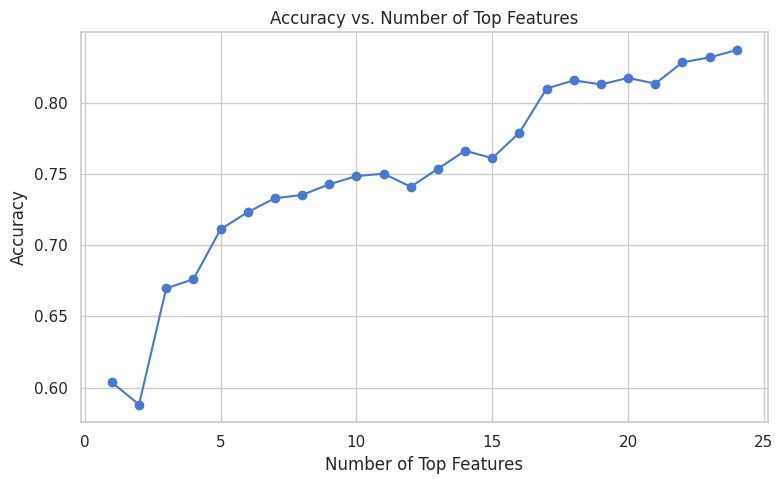


✅ Best accuracy = 0.8369 using top 24 features
Top 24 features:
 ['lbp_bin_7', 'lbp_bin_9', 'fractal_dim', 'p25_intensity', 'lbp_bin_5', 'lbp_bin_8', 'lbp_bin_3', 'lbp_bin_6', 'glcm_energy', 'lbp_bin_1', 'glcm_ASM', 'lbp_bin_0', 'entropy', 'glcm_dissimilarity', 'lbp_bin_2', 'glcm_contrast', 'glcm_correlation', 'mean_intensity', 'std_intensity', 'p75_intensity', 'glcm_homogeneity', 'asymmetry_mean', 'lbp_bin_4', 'max_intensity']


In [ ]:
# --- Load and prepare data ---
df = pd.read_csv("train_features.csv")
X_all = df.drop(columns=['label', 'label_name'], errors='ignore')
y = df['label']

# --- Rank features by ANOVA F-score ---
f_scores, _ = f_classif(X_all, y)
f_df = pd.DataFrame({
    "Feature": X_all.columns,
    "F_score": f_scores
}).sort_values(by="F_score", ascending=False)

# --- Try increasing number of top features ---
max_features = len(f_df)
accuracies = []

for n in range(1, max_features + 1):
    top_n_features = f_df['Feature'].iloc[:n].tolist()
    X_subset = X_all[top_n_features]

    X_train, X_test, y_train, y_test = train_test_split(
        X_subset, y, stratify=y, test_size=0.2, random_state=42
    )

    clf = RandomForestClassifier(
        max_depth=15,  # or experiment with 10–20
        class_weight='balanced_subsample',
        n_estimators=100,
        random_state=42
    )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

# --- Plot results ---
plt.figure(figsize=(8, 5))
plt.plot(range(1, max_features + 1), accuracies, marker='o')
plt.title("Accuracy vs. Number of Top Features")
plt.xlabel("Number of Top Features")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Print best result ---
best_n = max(range(1, max_features + 1), key=lambda i: accuracies[i - 1])
print(f"\n✅ Best accuracy = {accuracies[best_n - 1]:.4f} using top {best_n} features")
print(f"Top {best_n} features:\n", f_df['Feature'].iloc[:best_n].tolist())



🧪 Validation Set Performance
Accuracy: 0.8450520833333334
                      precision    recall  f1-score   support

       No Impairment       0.74      0.83      0.78       384
Very Mild Impairment       0.72      0.73      0.73       384
     Mild Impairment       0.94      0.85      0.89       384
 Moderate Impairment       1.00      0.97      0.99       384

            accuracy                           0.85      1536
           macro avg       0.85      0.85      0.85      1536
        weighted avg       0.85      0.85      0.85      1536


🧪 Test Set Performance
Accuracy: 0.691164972634871
                      precision    recall  f1-score   support

       No Impairment       0.74      0.83      0.78       640
Very Mild Impairment       0.63      0.63      0.63       448
     Mild Impairment       0.64      0.39      0.48       179
 Moderate Impairment       1.00      0.08      0.15        12

            accuracy                           0.69      1279
           macro

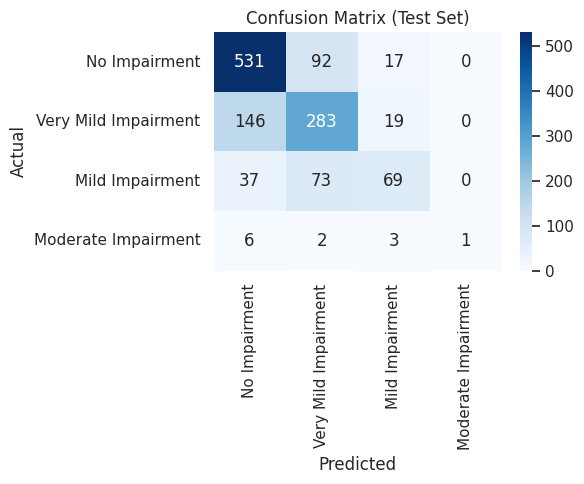

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import f_classif
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

train_df = pd.read_csv("train_features.csv")
val_df = pd.read_csv("val_features.csv")
test_df = pd.read_csv("test_features.csv")

label_map = {
    0: 'No Impairment',
    1: 'Very Mild Impairment',
    2: 'Mild Impairment',
    3: 'Moderate Impairment'
}

X_train_all = train_df.drop(columns=['label', 'label_name'], errors='ignore')
y_train = train_df['label']
X_val_all = val_df.drop(columns=['label', 'label_name'], errors='ignore')
y_val = val_df['label']
X_test_all = test_df.drop(columns=['label', 'label_name'], errors='ignore')
y_test = test_df['label']

# --- Choose Top-N Features (e.g., 10) ---
N = 24
top_features = f_df['Feature'].iloc[:N].tolist()

# Select same top features from all sets
X_train = X_train_all[top_features]
X_val = X_val_all[top_features]
X_test = X_test_all[top_features]

# --- Train Model ---
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=21)
clf.fit(X_train, y_train)

# --- Evaluate on Validation Set ---
y_val_pred = clf.predict(X_val)
print("\n🧪 Validation Set Performance")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred, target_names=label_map.values()))

# --- Evaluate on Test Set ---
y_test_pred = clf.predict(X_test)
print("\n🧪 Test Set Performance")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred, target_names=label_map.values()))

# --- Confusion Matrix for Test Set ---
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_map.values(), yticklabels=label_map.values())
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


/home/alof/anaconda3/envs/brainml/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:11:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🧪 XGBoost Validation Set Performance
Accuracy: 0.7955729166666666
                      precision    recall  f1-score   support

       No Impairment       0.70      0.73      0.72       384
Very Mild Impairment       0.64      0.67      0.66       384
     Mild Impairment       0.87      0.81      0.84       384
 Moderate Impairment       0.99      0.97      0.98       384

            accuracy                           0.80      1536
           macro avg       0.80      0.80      0.80      1536
        weighted avg       0.80      0.80      0.80      1536


🧪 XGBoost Test Set Performance
Accuracy: 0.5910867865519938
                      precision    recall  f1-score   support

       No Impairment       0.67      0.75      0.71       640
Very Mild Impairment       0.50      0.48      0.49       448
     Mild Impairment       0.45      0.35      0.39       179
 Moderate Impairment       1.00      0.08      0.15        12

            accuracy                           0.59      1279

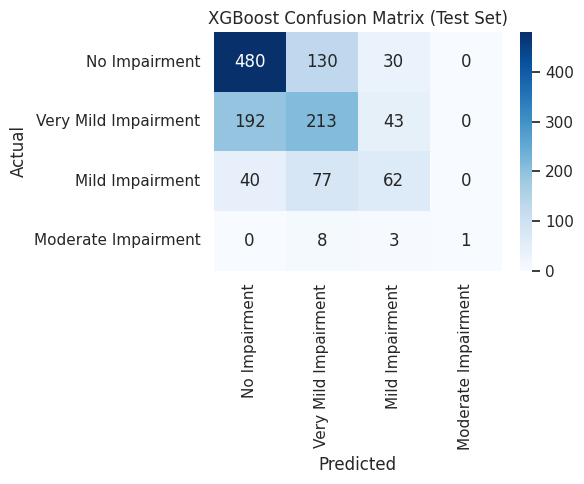

<Figure size 800x600 with 0 Axes>

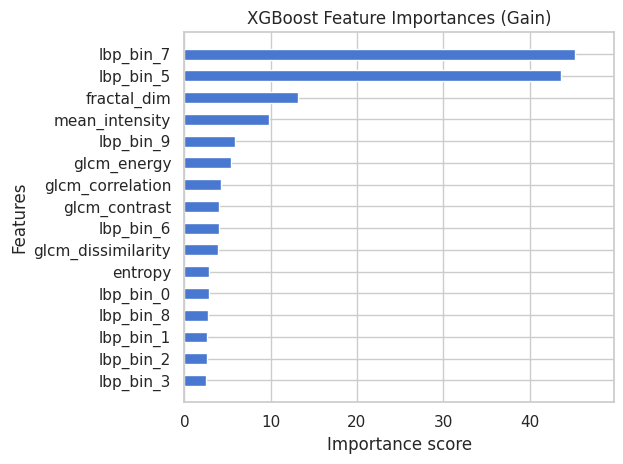

In [14]:
train_df = pd.read_csv("train_features.csv")
val_df = pd.read_csv("val_features.csv")
test_df = pd.read_csv("test_features.csv")

label_map = {
    0: 'No Impairment',
    1: 'Very Mild Impairment',
    2: 'Mild Impairment',
    3: 'Moderate Impairment'
}

# --- Prepare Data ---
X_train_all = train_df.drop(columns=['label', 'label_name'], errors='ignore')
y_train = train_df['label']
X_val_all = val_df.drop(columns=['label', 'label_name'], errors='ignore')
y_val = val_df['label']
X_test_all = test_df.drop(columns=['label', 'label_name'], errors='ignore')
y_test = test_df['label']

# --- Rank Top 18 Features from Training Set ---
f_scores, _ = f_classif(X_train_all, y_train)
f_df = pd.DataFrame({
    "Feature": X_train_all.columns,
    "F_score": f_scores
}).sort_values(by="F_score", ascending=False)

top_features = f_df['Feature'].iloc[:18].tolist()

X_train = X_train_all[top_features]
X_val = X_val_all[top_features]
X_test = X_test_all[top_features]

# --- Train XGBoost Model ---
xgb_model = XGBClassifier(
    objective='multi:softmax',
    num_class=4,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)
xgb_model.fit(X_train, y_train)

# --- Evaluate on Validation Set ---
y_val_pred = xgb_model.predict(X_val)
print("\n🧪 XGBoost Validation Set Performance")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred, target_names=label_map.values()))

# --- Evaluate on Test Set ---
y_test_pred = xgb_model.predict(X_test)
print("\n🧪 XGBoost Test Set Performance")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred, target_names=label_map.values()))

# --- Confusion Matrix for Test Set ---
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_map.values(), yticklabels=label_map.values())
plt.title("XGBoost Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# --- Feature Importances ---
plt.figure(figsize=(8, 6))
plot_importance(xgb_model, importance_type='gain', height=0.5, show_values=False)
plt.title("XGBoost Feature Importances (Gain)")
plt.tight_layout()
plt.show()

In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Caminhos
train_dir = "./data/train"
val_dir = "./data/val"
test_dir = "./data/test"

# Parâmetros
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 10

# Apenas normalização (sem augmentation)
datagen = ImageDataGenerator(rescale=1./255)

# Carregar datasets
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Base MobileNetV2 pré-treinada (sem as camadas finais)
base_model = MobileNetV2(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Inicialmente congelar

# Construir modelo
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

# Compilar
model.compile(
    optimizer=optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stop = callbacks.EarlyStopping(patience=3, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(patience=2, factor=0.5)

# Treinar
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stop, reduce_lr]
)

# ➤ FINE-TUNING: Descongela parte da base
base_model.trainable = True
model.compile(
    optimizer=optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Treinar novamente com fine-tuning
history_finetune = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stop, reduce_lr]
)

# Avaliar
loss, acc = model.evaluate(test_generator)
print(f"\n✅ Test Accuracy: {acc:.2%}")


Found 8704 images belonging to 4 classes.
Found 1536 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


2025-05-10 22:11:41.925436: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/10


/home/alof/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.5541 - loss: 1.0283

KeyboardInterrupt: 